# Baseline torch 3D - Vesuvius Challenge
Notebook de départ pour entraîner un petit modèle 3D (UNet simplifié) sur un échantillon et produire une première `submission.zip` Kaggle. Paramètres volontairement modestes pour un smoke test GPU.

In [1]:
!pip install -q tifffile pandas numpy torch torchvision tqdm scipy matplotlib


error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

In [2]:
import os
import random
import zipfile
from pathlib import Path

import numpy as np
import pandas as pd
import tifffile
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

DATA_ROOT = Path('../data/raw/vesuvius-challenge-surface-detection')
OUTPUT_DIR = Path('../outputs')
OUTPUT_DIR.mkdir(exist_ok=True)

train_df = pd.read_csv(DATA_ROOT / 'train.csv')
test_df = pd.read_csv(DATA_ROOT / 'test.csv')

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cuda


In [3]:
class VesuviusPatchDataset(Dataset):
    def __init__(self, ids, data_root, split='train', patch_size=96, max_patches_per_volume=8):
        self.ids = list(map(str, ids))
        self.data_root = Path(data_root)
        self.split = split
        self.patch_size = patch_size
        self.max_patches = max_patches_per_volume

    def __len__(self):
        # Nombre d'items = nb_volumes * nb_patches/volume pour chaque epoch
        return len(self.ids) * self.max_patches

    def _load_volume(self, vid):
        img_path = self.data_root / f'{self.split}_images' / f'{vid}.tif'
        vol = tifffile.imread(img_path)
        return vol.astype(np.float32) / 255.0

    def _load_label(self, vid):
        if self.split != 'train':
            return None
        lbl_path = self.data_root / 'train_labels' / f'{vid}.tif'
        lbl = tifffile.imread(lbl_path)
        return (lbl > 0).astype(np.float32)

    def __getitem__(self, idx):
        vidx = idx // self.max_patches
        vid = self.ids[vidx]
        vol = self._load_volume(vid)
        label = self._load_label(vid)

        d, h, w = vol.shape
        ps = self.patch_size
        # Gestion cas où volume < patch
        pad_z = max(0, ps - d)
        pad_y = max(0, ps - h)
        pad_x = max(0, ps - w)
        if pad_z or pad_y or pad_x:
            vol = np.pad(vol, ((0, pad_z), (0, pad_y), (0, pad_x)), mode='edge')
            if label is not None:
                label = np.pad(label, ((0, pad_z), (0, pad_y), (0, pad_x)), mode='edge')
            d, h, w = vol.shape

        z0 = random.randint(0, d - ps)
        y0 = random.randint(0, h - ps)
        x0 = random.randint(0, w - ps)

        img_patch = vol[z0:z0+ps, y0:y0+ps, x0:x0+ps]
        img_patch = torch.from_numpy(img_patch)[None]  # (1, D, H, W)

        if label is not None:
            lbl_patch = label[z0:z0+ps, y0:y0+ps, x0:x0+ps]
            lbl_patch = torch.from_numpy(lbl_patch)[None]
        else:
            lbl_patch = torch.zeros(1, ps, ps, ps, dtype=torch.float32)

        return img_patch, lbl_patch

In [4]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

class SimpleUNet3D(nn.Module):
    def __init__(self, base=8):
        super().__init__()
        self.down1 = ConvBlock(1, base)
        self.pool1 = nn.MaxPool3d(2)
        self.down2 = ConvBlock(base, base * 2)
        self.pool2 = nn.MaxPool3d(2)

        self.bottleneck = ConvBlock(base * 2, base * 4)

        self.up2 = nn.ConvTranspose3d(base * 4, base * 2, kernel_size=2, stride=2)
        self.conv2 = ConvBlock(base * 4, base * 2)
        self.up1 = nn.ConvTranspose3d(base * 2, base, kernel_size=2, stride=2)
        self.conv1 = ConvBlock(base * 2, base)

        self.head = nn.Conv3d(base, 1, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)
        d2 = self.down2(p1)
        p2 = self.pool2(d2)

        bn = self.bottleneck(p2)

        u2 = self.up2(bn)
        c2 = self.conv2(torch.cat([u2, d2], dim=1))
        u1 = self.up1(c2)
        c1 = self.conv1(torch.cat([u1, d1], dim=1))

        return self.head(c1)

In [10]:

# Échantillon minimal pour un run rapide + split train/val/test internes
subset_size = min(12, len(train_df))
sampled = train_df.sample(n=subset_size, random_state=42)['id'].tolist()

val_size = max(1, int(0.2 * subset_size))
test_size = max(1, int(0.2 * subset_size))
train_size = max(1, subset_size - val_size - test_size)

train_ids = list(map(str, sampled[:train_size]))
val_ids = list(map(str, sampled[train_size:train_size + val_size]))
holdout_ids = list(map(str, sampled[train_size + val_size:train_size + val_size + test_size]))

patch_size = 96
train_ds = VesuviusPatchDataset(train_ids, DATA_ROOT, split='train', patch_size=patch_size, max_patches_per_volume=8)
val_ds = VesuviusPatchDataset(val_ids, DATA_ROOT, split='train', patch_size=patch_size, max_patches_per_volume=4)
internal_test_ds = VesuviusPatchDataset(holdout_ids, DATA_ROOT, split='train', patch_size=patch_size, max_patches_per_volume=4)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)
internal_test_loader = DataLoader(internal_test_ds, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

model = SimpleUNet3D(base=8).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 10  # augmenter pour un vrai entraînement
print(f"Split interne -> train:{len(train_ids)} val:{len(val_ids)} test:{len(holdout_ids)}")


Split interne -> train:8 val:2 test:2


In [11]:

train_losses = []
val_losses = []

total_steps = num_epochs * len(train_loader)
with tqdm(total=total_steps, desc='Training', unit='batch') as pbar:
    for epoch in range(num_epochs):
        model.train()
        running = 0.0
        for imgs, lbls in train_loader:
            imgs = imgs.to(DEVICE)
            lbls = lbls.to(DEVICE)
            optimizer.zero_grad()
            logits = model(imgs)
            loss = criterion(logits, lbls)
            loss.backward()
            optimizer.step()
            running += loss.item()
            pbar.update(1)
        epoch_train = running / max(1, len(train_loader))
        train_losses.append(epoch_train)

        model.eval()
        val_running = 0.0
        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs = imgs.to(DEVICE)
                lbls = lbls.to(DEVICE)
                logits = model(imgs)
                val_running += criterion(logits, lbls).item()
        epoch_val = val_running / max(1, len(val_loader))
        val_losses.append(epoch_val)
        pbar.set_postfix({"epoch": epoch + 1, "train": f"{epoch_train:.4f}", "val": f"{epoch_val:.4f}"})

print('Loss finales -> train:', train_losses, 'val:', val_losses)


Training: 100%|██████████| 640/640 [01:00<00:00, 10.64batch/s, epoch=10, train=0.6565, val=0.6882]

Loss finales -> train: [0.6724289199337363, 0.6693201698362827, 0.6641712775453925, 0.6595896203070879, 0.662067680619657, 0.6611807597801089, 0.6513127349317074, 0.654114255681634, 0.6640037801116705, 0.6565211545675993] val: [0.6454820334911346, 0.7565803378820419, 0.6593424081802368, 0.7494927570223808, 0.6847536563873291, 0.657684937119484, 0.6741584986448288, 0.6824383959174156, 0.7172925397753716, 0.6882186830043793]


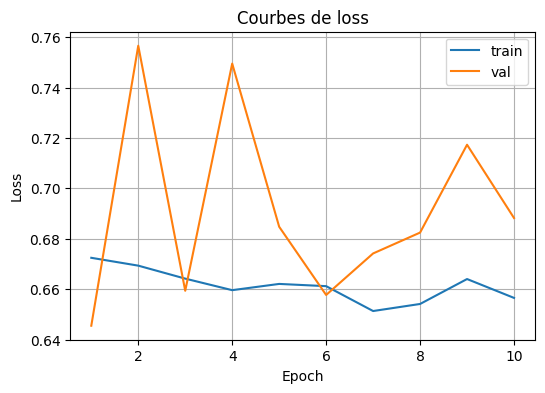

In [12]:

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(range(1, len(train_losses)+1), train_losses, label='train')
plt.plot(range(1, len(val_losses)+1), val_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Courbes de loss')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# Metrics proches de la compétition (SurfaceDice@tau et VOI_score)
import scipy.ndimage as ndi

def surface_dice(pred_mask: np.ndarray, gt_mask: np.ndarray, spacing=(1.0, 1.0, 1.0), tau: float = 2.0) -> float:
    pred = pred_mask > 0
    gt = gt_mask > 0
    if pred.sum() == 0 and gt.sum() == 0:
        return 1.0
    if pred.sum() == 0 or gt.sum() == 0:
        return 0.0
    dt_gt = ndi.distance_transform_edt(~gt, sampling=spacing)
    dt_pred = ndi.distance_transform_edt(~pred, sampling=spacing)
    dist_pred_to_gt = dt_gt[pred]
    dist_gt_to_pred = dt_pred[gt]
    return 0.5 * ((dist_pred_to_gt <= tau).mean() + (dist_gt_to_pred <= tau).mean())

def _entropy(probs: np.ndarray) -> float:
    probs = probs[probs > 0]
    if probs.size == 0:
        return 0.0
    return float(-(probs * np.log(probs)).sum())

def voi_score(pred_mask: np.ndarray, gt_mask: np.ndarray, alpha: float = 0.3) -> float:
    pred = pred_mask > 0
    gt = gt_mask > 0
    union = pred | gt
    if union.sum() == 0:
        return 1.0
    pred_labels, _ = ndi.label(pred)
    gt_labels, _ = ndi.label(gt)
    flat_pred = pred_labels[union].ravel()
    flat_gt = gt_labels[union].ravel()
    if flat_pred.size == 0:
        return 1.0
    max_p = int(flat_pred.max())
    max_g = int(flat_gt.max())
    cont = np.zeros((max_p + 1, max_g + 1), dtype=np.int64)
    np.add.at(cont, (flat_pred, flat_gt), 1)
    cont = cont[1:, 1:]  # enlever le background
    if cont.size == 0:
        return 1.0
    total = cont.sum()
    p_ij = cont / total
    a = p_ij.sum(axis=1)
    b = p_ij.sum(axis=0)
    H_pred = _entropy(a)
    H_gt = _entropy(b)
    # Mutual information
    mi = 0.0
    for i in range(p_ij.shape[0]):
        for j in range(p_ij.shape[1]):
            pij = p_ij[i, j]
            if pij > 0 and a[i] > 0 and b[j] > 0:
                mi += pij * np.log(pij / (a[i] * b[j]))
    vi = H_pred + H_gt - 2 * mi
    return 1.0 / (1.0 + alpha * vi)

def competition_like_score(pred_mask: np.ndarray, gt_mask: np.ndarray, topo_score: float | None = None) -> float:
    sd = surface_dice(pred_mask, gt_mask, tau=2.0)
    voi = voi_score(pred_mask, gt_mask, alpha=0.3)
    if topo_score is None:
        # renormalise en supposant TopoScore absent
        return (0.35 * sd + 0.35 * voi) / 0.7
    return 0.30 * topo_score + 0.35 * sd + 0.35 * voi

In [14]:

# Évaluation sur un volume de validation et un volume test interne (approximation du score compet)
val_id = val_ids[0]
val_img = tifffile.imread(DATA_ROOT / 'train_images' / f'{val_id}.tif').astype(np.float32) / 255.0
val_gt = tifffile.imread(DATA_ROOT / 'train_labels' / f'{val_id}.tif').astype(np.uint8)

holdout_id = holdout_ids[0]
test_img_int = tifffile.imread(DATA_ROOT / 'train_images' / f'{holdout_id}.tif').astype(np.float32) / 255.0
test_gt_int = tifffile.imread(DATA_ROOT / 'train_labels' / f'{holdout_id}.tif').astype(np.uint8)

ps = patch_size
stride = ps  # stride large pour aller vite

def infer_volume(img_vol):
    D, H, W = img_vol.shape
    pred = np.zeros((D, H, W), dtype=np.float32)
    counts = np.zeros_like(pred)
    model.eval()
    with torch.no_grad():
        for z0 in range(0, max(1, D - ps + 1), stride):
            for y0 in range(0, max(1, H - ps + 1), stride):
                for x0 in range(0, max(1, W - ps + 1), stride):
                    z1 = min(z0 + ps, D)
                    y1 = min(y0 + ps, H)
                    x1 = min(x0 + ps, W)
                    z0_adj = max(0, z1 - ps)
                    y0_adj = max(0, y1 - ps)
                    x0_adj = max(0, x1 - ps)

                    patch = img_vol[z0_adj:z1, y0_adj:y1, x0_adj:x1]
                    pad_z = ps - patch.shape[0]
                    pad_y = ps - patch.shape[1]
                    pad_x = ps - patch.shape[2]
                    if pad_z or pad_y or pad_x:
                        patch = np.pad(patch, ((0, pad_z), (0, pad_y), (0, pad_x)), mode='edge')

                    tensor = torch.from_numpy(patch)[None, None].to(DEVICE)
                    prob = torch.sigmoid(model(tensor)).cpu().numpy()[0, 0]

                    pred[z0_adj:z1, y0_adj:y1, x0_adj:x1] += prob[: z1 - z0_adj, : y1 - y0_adj, : x1 - x0_adj]
                    counts[z0_adj:z1, y0_adj:y1, x0_adj:x1] += 1
    pred = pred / np.maximum(1, counts)
    return (pred > 0.5).astype(np.uint8)

pred_val = infer_volume(val_img)
pred_test_int = infer_volume(test_img_int)

sd_val = surface_dice(pred_val, val_gt, tau=2.0)
voi_val = voi_score(pred_val, val_gt, alpha=0.3)
score_val = competition_like_score(pred_val, val_gt, topo_score=None)

sd_test = surface_dice(pred_test_int, test_gt_int, tau=2.0)
voi_test = voi_score(pred_test_int, test_gt_int, alpha=0.3)
score_test = competition_like_score(pred_test_int, test_gt_int, topo_score=None)

print(f"Validation volume {val_id} → SurfaceDice@2: {sd_val:.4f} | VOI_score: {voi_val:.4f} | Score approx: {score_val:.4f}")
print(f"Test interne volume {holdout_id} → SurfaceDice@2: {sd_test:.4f} | VOI_score: {voi_test:.4f} | Score approx: {score_test:.4f}")


Validation volume 2306395636 → SurfaceDice@2: 0.7665 | VOI_score: 0.7118 | Score approx: 0.7391
Test interne volume 324225693 → SurfaceDice@2: 0.7792 | VOI_score: 0.7305 | Score approx: 0.7548


In [15]:
# Inférence simple sur le test (1 volume ici)
test_id = str(test_df.iloc[0]['id'])
img_path = DATA_ROOT / 'test_images' / f'{test_id}.tif'
vol = tifffile.imread(img_path).astype(np.float32) / 255.0
D, H, W = vol.shape

ps = patch_size
stride = ps  # stride égal à la taille du patch pour aller vite
pred_volume = np.zeros((D, H, W), dtype=np.float32)
counts = np.zeros_like(pred_volume)

model.eval()
with torch.no_grad():
    for z0 in range(0, max(1, D - ps + 1), stride):
        for y0 in range(0, max(1, H - ps + 1), stride):
            for x0 in range(0, max(1, W - ps + 1), stride):
                z1 = min(z0 + ps, D)
                y1 = min(y0 + ps, H)
                x1 = min(x0 + ps, W)
                z0_adj = max(0, z1 - ps)
                y0_adj = max(0, y1 - ps)
                x0_adj = max(0, x1 - ps)

                patch = vol[z0_adj:z1, y0_adj:y1, x0_adj:x1]
                # pad si bord
                pad_z = ps - patch.shape[0]
                pad_y = ps - patch.shape[1]
                pad_x = ps - patch.shape[2]
                if pad_z or pad_y or pad_x:
                    patch = np.pad(patch, ((0, pad_z), (0, pad_y), (0, pad_x)), mode='edge')

                tensor = torch.from_numpy(patch)[None, None].to(DEVICE)
                logit = model(tensor)
                prob = torch.sigmoid(logit).cpu().numpy()[0, 0]

                pred_volume[z0_adj:z1, y0_adj:y1, x0_adj:x1] += prob[: z1 - z0_adj, : y1 - y0_adj, : x1 - x0_adj]
                counts[z0_adj:z1, y0_adj:y1, x0_adj:x1] += 1

pred_volume = pred_volume / np.maximum(1, counts)
mask = (pred_volume > 0.5).astype(np.uint8) * 255

out_path = OUTPUT_DIR / f'{test_id}.tif'
tifffile.imwrite(out_path, mask, compression='zlib')
print('Sauvé :', out_path)

zip_path = OUTPUT_DIR / 'submission.zip'
with zipfile.ZipFile(zip_path, 'w', compression=zipfile.ZIP_DEFLATED) as zf:
    zf.write(out_path, arcname=f'{test_id}.tif')
print('Zip prêt pour Kaggle :', zip_path)

Sauvé : ../outputs/1407735.tif
Zip prêt pour Kaggle : ../outputs/submission.zip
